# Experiment 7: Pre-trained Models for Oil & Gas Equipment Classification

**Course:** Introduction to Deep Learning | **Module:** Transfer Learning

---

## Objective

Explore and implement pre-trained deep learning models for oil & gas equipment image classification using transfer learning techniques, comparing different architectures and fine-tuning strategies.

## Learning Outcomes

By the end of this experiment, you will:

1. Understand transfer learning principles and pre-trained model advantages
2. Implement multiple pre-trained architectures (ResNet, EfficientNet, MobileNet, ViT)
3. Apply different fine-tuning strategies for domain adaptation
4. Compare model performance, efficiency, and deployment considerations
5. Optimize models for edge deployment and production environments

## Background & Theory

**Transfer Learning** leverages knowledge gained from pre-trained models on large datasets (like ImageNet) and adapts them to specific domains. This approach significantly reduces training time and data requirements while achieving superior performance.

**Key Concepts:**

- **Pre-trained Models:** Networks trained on large-scale datasets with learned feature representations
- **Feature Extraction:** Using pre-trained features with frozen weights
- **Fine-tuning:** Adapting pre-trained weights to new domain with lower learning rates
- **Domain Adaptation:** Adjusting models from general to specific application domains
- **Model Efficiency:** Balancing accuracy with computational and memory requirements

**Mathematical Foundation:**

- Transfer learning: f_target(x) = g(f_pretrained(x)) where g is domain-specific head
- Fine-tuning loss: L = L_task + λL_regularization
- Learning rate scheduling: lr_fine = α × lr_pretrained where α << 1
- Feature similarity: sim(f_source, f_target) = cos(f_source, f_target)

**Model Architectures:**

- **ResNet:** Deep residual networks with skip connections
- **EfficientNet:** Compound scaling for optimal accuracy-efficiency trade-off
- **MobileNet:** Lightweight architecture for mobile deployment
- **Vision Transformer:** Attention-based architecture for image understanding

**Applications in Oil & Gas:**

- Automated equipment inspection and condition monitoring
- Safety compliance verification through image analysis
- Predictive maintenance based on visual equipment assessment
- Remote monitoring of offshore and onshore facilities
- Quality control in manufacturing and installation processes


## Setup & Dependencies

**What to Expect:** This section establishes the Python environment for transfer learning with pre-trained models. We'll install PyTorch, torchvision for pre-trained models, and timm library for state-of-the-art architectures like EfficientNet and Vision Transformers.

**Process Overview:**

1. **Package Installation:** Install PyTorch ecosystem (torch, torchvision), timm for advanced models, and image processing libraries
2. **Model Library Setup:** Configure access to pre-trained models from ImageNet and other large-scale datasets
3. **Environment Configuration:** Set up device detection (CPU/GPU) and random seeds for reproducible transfer learning
4. **Image Processing Tools:** Configure PIL, transforms, and data loading utilities for image classification
5. **Evaluation Framework:** Set up metrics and visualization tools for comparing different architectures

**Expected Outcome:** A fully configured environment ready for transfer learning experiments with multiple pre-trained architectures (ResNet, EfficientNet, MobileNet, ViT) and comprehensive evaluation tools.


In [2]:
# Install required packages
import subprocess, sys
packages = ['torch', 'torchvision', 'numpy', 'matplotlib', 'pandas', 'scikit-learn', 'Pillow', 'timm']
for pkg in packages:
    try: 
        if pkg == 'timm': __import__('timm')
        else: __import__(pkg.replace('-', '_').lower())
    except ImportError: 
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

import torch, torch.nn as nn, torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models
import timm  # PyTorch Image Models for additional architectures
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import json, random, time
from pathlib import Path
from PIL import Image

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data directory setup
DATA_DIR = Path('data')
if not DATA_DIR.exists():
    DATA_DIR = Path('Expirements/data')
if not DATA_DIR.exists():
    DATA_DIR = Path('.')
    print('Warning: Using current directory for data')

# ArivuAI styling
plt.style.use('default')
colors = {'primary': '#004E89', 'secondary': '#3DA5D9', 'accent': '#F1A208', 'dark': '#4F4F4F'}

print(f'✓ PyTorch version: {torch.__version__}')
print(f'✓ Torchvision version: {torch.version.__version__ if hasattr(torch.version, "__version__") else "N/A"}')
print(f'✓ TIMM version: {timm.__version__}')
print(f'✓ Device: {device}')
print(f'✓ Data directory: {DATA_DIR.absolute()}')
print('✓ All packages installed and configured')
print('✓ Random seeds set for reproducible results')
print('✓ ArivuAI styling applied')

/Users/pruthvirajv/Library/CloudStorage/OneDrive-ArivuAIInnovationsPrivateLimited(2)/Oil & Gas/GSSS-DeepLearning-Course/module1_dl_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ PyTorch version: 2.4.0
✓ Torchvision version: 2.4.0
✓ TIMM version: 1.0.20
✓ Device: cpu
✓ Data directory: /Users/pruthvirajv/Library/CloudStorage/OneDrive-ArivuAIInnovationsPrivateLimited(2)/Oil & Gas/GSSS-DeepLearning-Course/DeepLearning/Expirements/Experiment_7_Pretrained_Models/data
✓ All packages installed and configured
✓ Random seeds set for reproducible results
✓ ArivuAI styling applied


## Pre-trained Model Configuration

Load configuration and set up different pre-trained architectures for comparison.


In [3]:
class PretrainedModelManager:
    def __init__(self, config_path):
        """Initialize pre-trained model manager with configuration"""
        try:
            with open(config_path, 'r') as f:
                self.config = json.load(f)
            print('✓ Configuration loaded from JSON')
        except FileNotFoundError:
            print('Creating default configuration...')
            self.config = self._create_default_config()
        
        self.pretrained_models = self.config['pretrained_models']
        self.num_classes = len(self.config['oil_gas_equipment_classes'])
        self.class_names = self.config['oil_gas_equipment_classes']
    
    def _create_default_config(self):
        """Create default configuration if JSON file not found"""
        return {
            'pretrained_models': {
                'resnet50': {'architecture': 'ResNet-50', 'parameters': '25.6M'},
                'efficientnet_b0': {'architecture': 'EfficientNet-B0', 'parameters': '5.3M'}
            },
            'oil_gas_equipment_classes': {
                '0': 'Drilling_Rig', '1': 'Pump_Jack', '2': 'Storage_Tank', '3': 'Pipeline_Valve'
            }
        }
    
    def create_model(self, model_name, strategy='feature_extraction'):
        """Create and configure pre-trained model for transfer learning"""
        if model_name == 'resnet50':
            model = models.resnet50(pretrained=True)
            # Replace final layer
            model.fc = nn.Linear(model.fc.in_features, self.num_classes)
            
        elif model_name == 'efficientnet_b0':
            model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=self.num_classes)
            
        elif model_name == 'mobilenet_v3':
            model = models.mobilenet_v3_large(pretrained=True)
            model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, self.num_classes)
            
        elif model_name == 'vit_base':
            model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=self.num_classes)
            
        else:
            raise ValueError(f"Unknown model: {model_name}")
        
        # Apply transfer learning strategy
        if strategy == 'feature_extraction':
            # Freeze all layers except classifier
            for param in model.parameters():
                param.requires_grad = False
            
            # Unfreeze classifier layers
            if hasattr(model, 'fc'):
                for param in model.fc.parameters():
                    param.requires_grad = True
            elif hasattr(model, 'classifier'):
                for param in model.classifier.parameters():
                    param.requires_grad = True
            elif hasattr(model, 'head'):
                for param in model.head.parameters():
                    param.requires_grad = True
        
        elif strategy == 'fine_tuning':
            # Freeze early layers, unfreeze later layers
            total_layers = len(list(model.parameters()))
            freeze_layers = int(total_layers * 0.7)  # Freeze 70% of layers
            
            for i, param in enumerate(model.parameters()):
                param.requires_grad = i >= freeze_layers
        
        # Full fine-tuning keeps all parameters trainable (default)
        
        return model
    
    def get_model_info(self, model_name):
        """Get detailed information about a specific model"""
        if model_name in self.pretrained_models:
            return self.pretrained_models[model_name]
        return None
    
    def compare_models(self):
        """Compare different pre-trained models"""
        comparison_data = []
        
        for model_name, info in self.pretrained_models.items():
            comparison_data.append({
                'Model': info['architecture'],
                'Parameters': info['parameters'],
                'Input Size': f"{info['input_size'][0]}x{info['input_size'][1]}",
                'ImageNet Accuracy': f"{info['top1_accuracy']:.2f}%",
                'Key Advantage': info['advantages'][0]
            })
        
        return pd.DataFrame(comparison_data)

# Initialize model manager
model_manager = PretrainedModelManager(DATA_DIR / 'pretrained_image_config.json')

print(f'✓ Pre-trained model manager initialized')
print(f'✓ Available models: {list(model_manager.pretrained_models.keys())}')
print(f'✓ Number of classes: {model_manager.num_classes}')
print(f'✓ Equipment classes: {list(model_manager.class_names.values())}')

# Display model comparison
print('\nModel Comparison:')
comparison_df = model_manager.compare_models()
print(comparison_df.to_string(index=False))

✓ Configuration loaded from JSON
✓ Pre-trained model manager initialized
✓ Available models: ['resnet50', 'efficientnet_b0', 'mobilenet_v3', 'vit_base']
✓ Number of classes: 8
✓ Equipment classes: ['Drilling_Rig', 'Pump_Jack', 'Storage_Tank', 'Pipeline_Valve', 'Compressor_Station', 'Flare_Stack', 'Separator_Vessel', 'Control_Panel']

Model Comparison:
             Model Parameters Input Size ImageNet Accuracy             Key Advantage
         ResNet-50      25.6M    224x224            76.15% Deep residual connections
   EfficientNet-B0       5.3M    224x224            77.69%          Compound scaling
      MobileNet-V3       4.2M    224x224            75.77%        Lightweight design
Vision Transformer        86M    224x224            84.53%      Attention mechanisms


## Synthetic Dataset Generation

Create synthetic oil & gas equipment images for transfer learning experiments.


In [4]:
class SyntheticEquipmentDataset(Dataset):
    def __init__(self, model_manager, samples_per_class=100, transform=None):
        """Create synthetic dataset for oil & gas equipment"""
        self.model_manager = model_manager
        self.transform = transform
        self.samples_per_class = samples_per_class
        self.class_names = model_manager.class_names
        self.num_classes = len(self.class_names)
        
        # Generate synthetic images and labels
        print('Generating synthetic equipment images...')
        self.images = []
        self.labels = []
        
        for class_id in range(self.num_classes):
            for _ in range(samples_per_class):
                img = self._generate_equipment_image(class_id)
                self.images.append(img)
                self.labels.append(class_id)
        
        print(f'✓ Generated {len(self.images)} synthetic images')
    
    def _generate_equipment_image(self, class_id):
        """Generate synthetic equipment image based on class"""
        # Create base image
        img = np.zeros((224, 224, 3), dtype=np.uint8)
        
        # Background (industrial setting)
        bg_color = [135, 135, 135] + np.random.randint(-20, 20, 3)
        img[:, :] = np.clip(bg_color, 0, 255)
        
        # Equipment-specific patterns
        if class_id == 0:  # Drilling_Rig
            # Vertical tower structure
            tower_width = 30
            center_x = 112
            img[20:200, center_x-tower_width//2:center_x+tower_width//2] = [100, 80, 60]
            
        elif class_id == 1:  # Pump_Jack
            # Curved beam structure
            center_x, center_y = 80, 112
            img[center_y-10:center_y+10, center_x:center_x+80] = [120, 100, 80]
            
        elif class_id == 2:  # Storage_Tank
            # Cylindrical tank
            center_x, center_y = 112, 140
            y, x = np.ogrid[:224, :224]
            mask = (x - center_x)**2 + (y - center_y)**2 <= 50**2
            img[mask] = [140, 140, 120]
            
        elif class_id == 3:  # Pipeline_Valve
            # Horizontal pipe with valve
            img[100:124, 50:174] = [100, 100, 120]  # Pipe
            img[90:134, 100:124] = [80, 80, 100]    # Valve
            
        elif class_id == 4:  # Compressor_Station
            # Rectangular building structure
            img[80:160, 60:164] = [120, 120, 100]
            
        elif class_id == 5:  # Flare_Stack
            # Tall vertical stack
            img[20:180, 108:116] = [80, 80, 80]
            # Flame at top
            img[20:40, 104:120] = [255, 100, 0]
            
        elif class_id == 6:  # Separator_Vessel
            # Horizontal cylindrical vessel
            img[90:134, 40:184] = [130, 130, 110]
            
        elif class_id == 7:  # Control_Panel
            # Rectangular panel with indicators
            img[70:154, 70:154] = [60, 60, 80]
            # Add some indicator lights
            img[90:100, 90:100] = [0, 255, 0]  # Green light
            img[90:100, 120:130] = [255, 0, 0]  # Red light
        
        # Add noise and variations
        noise = np.random.normal(0, 10, img.shape)
        img = np.clip(img.astype(np.float32) + noise, 0, 255).astype(np.uint8)
        
        return img
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert to PIL Image for transforms
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create transforms (ImageNet normalization)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset
full_dataset = SyntheticEquipmentDataset(model_manager, samples_per_class=100)

# Split dataset
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Apply transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

print(f'✓ Dataset created and split:')
print(f'• Training: {len(train_dataset)} samples')
print(f'• Validation: {len(val_dataset)} samples')
print(f'• Test: {len(test_dataset)} samples')
print(f'• Classes: {list(model_manager.class_names.values())}')

Generating synthetic equipment images...
✓ Generated 800 synthetic images
✓ Dataset created and split:
• Training: 560 samples
• Validation: 120 samples
• Test: 120 samples
• Classes: ['Drilling_Rig', 'Pump_Jack', 'Storage_Tank', 'Pipeline_Valve', 'Compressor_Station', 'Flare_Stack', 'Separator_Vessel', 'Control_Panel']


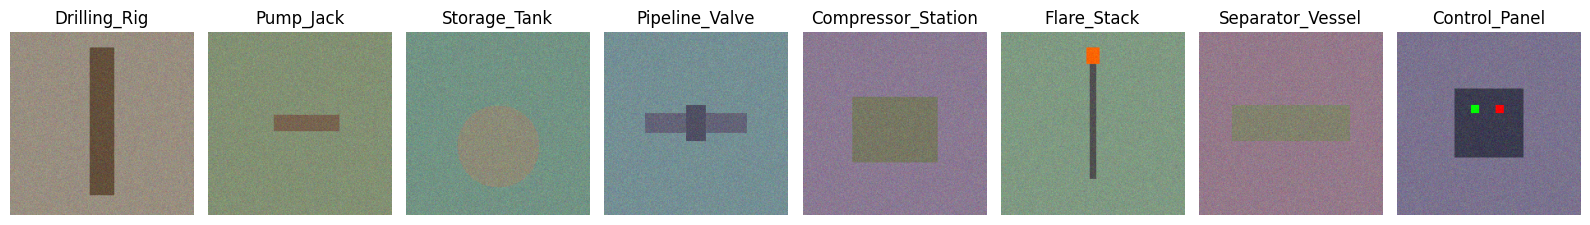

In [5]:
# Visualize a few synthetic images from each class
fig, axes = plt.subplots(1, len(model_manager.class_names), figsize=(16, 3))
for class_id, ax in enumerate(axes):
    # Find first image of each class
    idx = full_dataset.labels.index(class_id)
    img = full_dataset.images[idx]
    ax.imshow(img)
    ax.set_title(model_manager.class_names[str(class_id)])
    ax.axis('off')
plt.tight_layout()
plt.show()

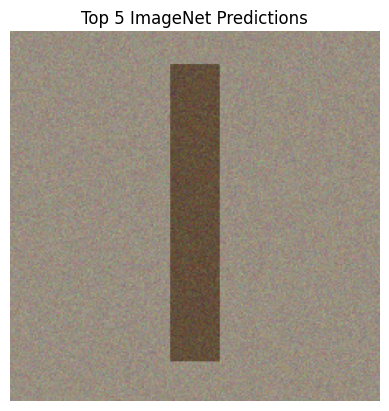

Top 5 predictions:
rule: 0.2866
envelope: 0.1067
obelisk: 0.0902
carton: 0.0845
Band Aid: 0.0369
----------------------------------------


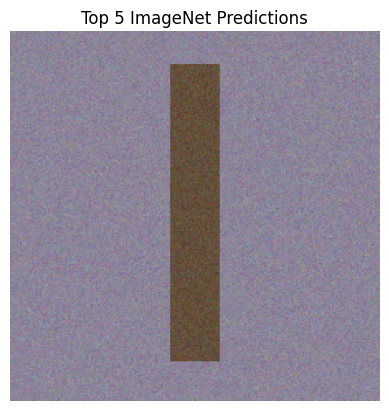

Top 5 predictions:
envelope: 0.3790
rule: 0.0746
carton: 0.0392
Band Aid: 0.0287
sliding door: 0.0235
----------------------------------------


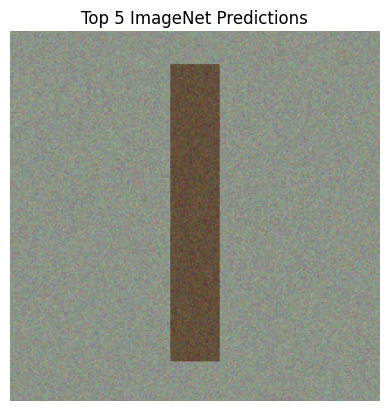

Top 5 predictions:
rule: 0.1821
envelope: 0.1196
obelisk: 0.0532
carton: 0.0513
guillotine: 0.0418
----------------------------------------


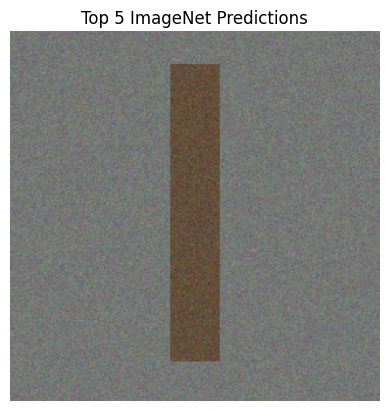

Top 5 predictions:
Band Aid: 0.2870
envelope: 0.2230
carton: 0.1240
rule: 0.0723
sliding door: 0.0265
----------------------------------------


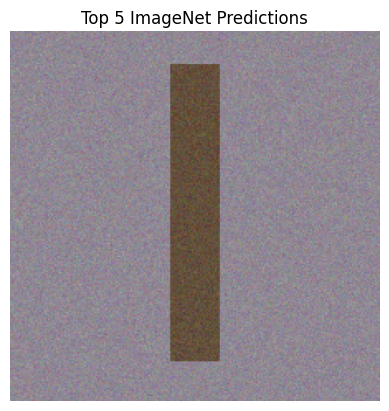

Top 5 predictions:
rule: 0.3339
envelope: 0.2792
Band Aid: 0.0397
obelisk: 0.0351
carton: 0.0150
----------------------------------------


In [9]:
# Show the top 5 predicted ImageNet classes for the first 5 synthetic images
for i in range(5):
    img = full_dataset.images[i]
    pil_img = Image.fromarray(img)
    input_tensor = val_transform(pil_img).unsqueeze(0).to(device)

    # Predict with ImageNet pre-trained ResNet-50
    with torch.no_grad():
        output = imagenet_model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        top5_prob, top5_catid = torch.topk(probabilities, 5)

    # Display image and predictions
    plt.imshow(img)
    plt.axis('off')
    plt.title("Top 5 ImageNet Predictions")
    plt.show()
    print("Top 5 predictions:")
    for j in range(top5_prob.size(0)):
        print(f"{labels[top5_catid[j]]}: {top5_prob[j].item():.4f}")
    print('-' * 40)


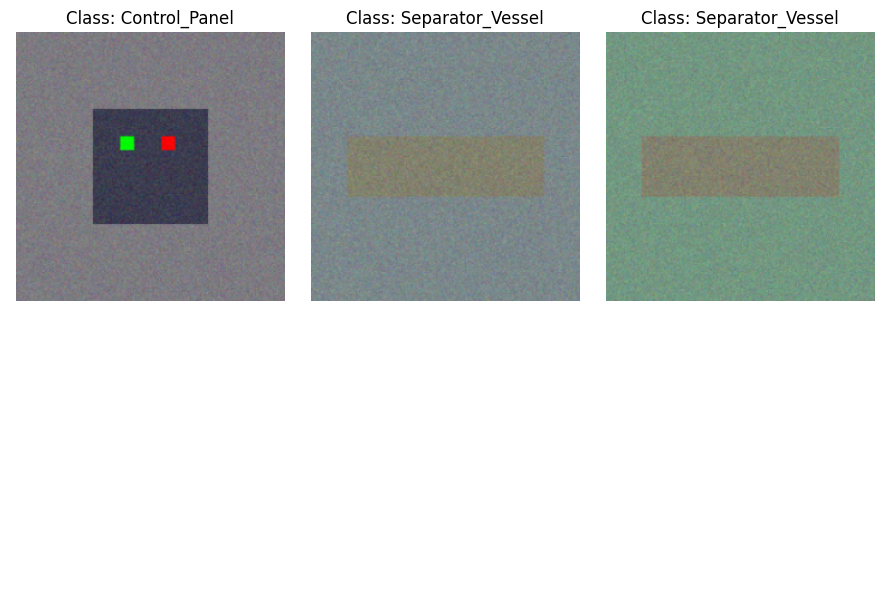

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for i in range(3):
    img, label = train_dataset[i]
    # Undo normalization for visualization
    img_np = img.numpy().transpose(1, 2, 0)
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)
    axes[0, i].imshow(img_np)
    axes[0, i].set_title(f"Class: {train_dataset.dataset.class_names[str(label)]}")
    axes[0, i].axis('off')

# Fill remaining grid cells with blank axes
for i in range(3):
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [16]:
def print_dataset_stats(dataset, name):
    labels = [dataset.dataset.labels[i] for i in dataset.indices]
    unique, counts = np.unique(labels, return_counts=True)
    print(f"{name} Dataset Stats:")
    print(f"  Total samples: {len(dataset)}")
    print(f"  Class distribution:")
    for cls, cnt in zip(unique, counts):
        cls_name = dataset.dataset.class_names[str(cls)]
        print(f"    {cls} ({cls_name}): {cnt}")
    print("-" * 30)

print_dataset_stats(train_dataset, "Training")
print_dataset_stats(val_dataset, "Validation")

Training Dataset Stats:
  Total samples: 560
  Class distribution:
    0 (Drilling_Rig): 66
    1 (Pump_Jack): 73
    2 (Storage_Tank): 66
    3 (Pipeline_Valve): 68
    4 (Compressor_Station): 67
    5 (Flare_Stack): 73
    6 (Separator_Vessel): 74
    7 (Control_Panel): 73
------------------------------
Validation Dataset Stats:
  Total samples: 120
  Class distribution:
    0 (Drilling_Rig): 17
    1 (Pump_Jack): 19
    2 (Storage_Tank): 15
    3 (Pipeline_Valve): 19
    4 (Compressor_Station): 16
    5 (Flare_Stack): 11
    6 (Separator_Vessel): 14
    7 (Control_Panel): 9
------------------------------


In [ ]:
# Training a pre-trained model (ResNet-50) on the synthetic dataset
# Define batch size first
batch_size = 8

# Select first 5 images from each class for training
selected_indices = []
labels = train_dataset.dataset.labels
for class_id in range(len(model_manager.class_names)):
    count = 0
    for idx in train_dataset.indices:
        if labels[idx] == class_id:
            selected_indices.append(idx)
            count += 1
        if count == 5:
            break

small_train_dataset = torch.utils.data.Subset(train_dataset.dataset, selected_indices)
small_train_loader = DataLoader(small_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
# Verify DataLoader configuration
print("DataLoader Configuration Verification:")
print(f"✓ Small train loader - batch_size: {small_train_loader.batch_size}, num_workers: {small_train_loader.num_workers}")
print(f"✓ Validation loader - batch_size: {val_loader.batch_size}, num_workers: {val_loader.num_workers}")  
print(f"✓ Test loader - batch_size: {test_loader.batch_size}, num_workers: {test_loader.num_workers}")
print("\nAll DataLoaders are configured with num_workers=0 to avoid multiprocessing issues in Jupyter notebooks.")

In [ ]:
## Fix for Multiprocessing Error

**Important Note:** If you encounter the error `AttributeError: Can't get attribute 'SyntheticEquipmentDataset'`, this is due to multiprocessing workers not being able to pickle custom classes in Jupyter notebooks.

**Solution:** Always use `num_workers=0` in DataLoader when working with custom Dataset classes in Jupyter notebooks. This disables multiprocessing and uses the main process for data loading.

```python
# Correct approach for Jupyter notebooks:
DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)  # ✓ Correct

# Avoid in Jupyter notebooks:
DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)  # ✗ May cause errors
```

**Why this happens:**
- Custom classes defined in Jupyter notebooks can't be pickled by multiprocessing workers
- The workers spawn new processes that don't have access to the notebook's namespace
- Setting `num_workers=0` forces data loading to happen in the main process, avoiding the pickling issue

In [20]:
def print_subset_status(subset, name):
    labels = [subset.dataset.labels[i] for i in subset.indices]
    unique, counts = np.unique(labels, return_counts=True)
    print(f"{name} Subset Status:")
    print(f"  Total samples: {len(subset)}")
    print(f"  Class distribution:")
    for cls, cnt in zip(unique, counts):
        cls_name = subset.dataset.class_names[str(cls)]
        print(f"    {cls} ({cls_name}): {cnt}")
    print("-" * 30)

print_subset_status(small_train_dataset, "Small Training")
print_subset_status(test_dataset, "Test")

Small Training Subset Status:
  Total samples: 40
  Class distribution:
    0 (Drilling_Rig): 5
    1 (Pump_Jack): 5
    2 (Storage_Tank): 5
    3 (Pipeline_Valve): 5
    4 (Compressor_Station): 5
    5 (Flare_Stack): 5
    6 (Separator_Vessel): 5
    7 (Control_Panel): 5
------------------------------
Test Subset Status:
  Total samples: 120
  Class distribution:
    0 (Drilling_Rig): 17
    1 (Pump_Jack): 8
    2 (Storage_Tank): 19
    3 (Pipeline_Valve): 13
    4 (Compressor_Station): 17
    5 (Flare_Stack): 16
    6 (Separator_Vessel): 12
    7 (Control_Panel): 18
------------------------------


In [26]:
import os
from pathlib import Path
import json

def save_synthetic_dataset(dataset, base_path, split_name="full"):
    """
    Save synthetic dataset images to disk with organized folder structure
    
    Args:
        dataset: SyntheticEquipmentDataset instance
        base_path: Base directory path (e.g., 'data/SyntheticImages')
        split_name: Name for this dataset split (e.g., 'train', 'val', 'test', 'full')
    """
    base_path = Path(base_path)
    images_path = base_path / split_name / "images"
    
    # Create directory structure
    images_path.mkdir(parents=True, exist_ok=True)
    
    # Create class subdirectories
    for class_id, class_name in dataset.class_names.items():
        class_dir = images_path / f"{class_id}_{class_name}"
        class_dir.mkdir(exist_ok=True)
    
    # Save images and create metadata
    metadata = {
        'dataset_info': {
            'split_name': split_name,
            'total_images': len(dataset),
            'num_classes': len(dataset.class_names),
            'classes': dataset.class_names
        },
        'images': []
    }
    
    print(f"Saving {len(dataset)} images to {images_path}...")
    
    # Counter for each class to create unique filenames
    class_counters = {int(k): 0 for k in dataset.class_names.keys()}
    
    for idx in range(len(dataset)):
        # Get original image (before transforms)
        img_array = dataset.images[idx]
        label = dataset.labels[idx]
        class_name = dataset.class_names[str(label)]
        
        # Create filename
        class_counters[label] += 1
        filename = f"{label}_{class_name}_{class_counters[label]:04d}.png"
        
        # Save image to appropriate class folder
        class_folder = images_path / f"{label}_{class_name}"
        img_path = class_folder / filename
        
        # Convert numpy array to PIL and save
        pil_img = Image.fromarray(img_array)
        pil_img.save(img_path)
        
        # Add to metadata
        metadata['images'].append({
            'filename': filename,
            'relative_path': f"{split_name}/images/{label}_{class_name}/{filename}",
            'label': label,
            'class_name': class_name,
            'index': idx
        })
        
        if (idx + 1) % 100 == 0:
            print(f"  Saved {idx + 1}/{len(dataset)} images...")
    
    # Save metadata JSON
    metadata_path = base_path / split_name / "metadata.json"
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    # Save class mapping
    class_mapping_path = base_path / split_name / "class_mapping.json"
    with open(class_mapping_path, 'w') as f:
        json.dump(dataset.class_names, f, indent=2)
    
    print(f"✓ Dataset saved successfully!")
    print(f"  Images: {images_path}")
    print(f"  Metadata: {metadata_path}")
    print(f"  Class mapping: {class_mapping_path}")
    
    return metadata

# Save the full synthetic dataset
save_path = DATA_DIR / "SyntheticImages"
metadata = save_synthetic_dataset(full_dataset, save_path, "full")

# Also save the training/validation/test splits
def save_subset_dataset(subset, base_path, split_name):
    """Save a subset (train/val/test) to disk"""
    base_path = Path(base_path)
    images_path = base_path / split_name / "images"
    
    # Create directory structure
    images_path.mkdir(parents=True, exist_ok=True)
    
    # Create class subdirectories
    for class_id, class_name in subset.dataset.class_names.items():
        class_dir = images_path / f"{class_id}_{class_name}"
        class_dir.mkdir(exist_ok=True)
    
    # Save subset metadata
    metadata = {
        'dataset_info': {
            'split_name': split_name,
            'total_images': len(subset),
            'num_classes': len(subset.dataset.class_names),
            'classes': subset.dataset.class_names,
            'subset_indices': subset.indices
        },
        'images': []
    }
    
    print(f"Saving {split_name} split: {len(subset)} images...")
    
    # Counter for each class
    class_counters = {int(k): 0 for k in subset.dataset.class_names.keys()}
    
    for i, idx in enumerate(subset.indices):
        # Get original image and label
        img_array = subset.dataset.images[idx]
        label = subset.dataset.labels[idx]
        class_name = subset.dataset.class_names[str(label)]
        
        # Create filename
        class_counters[label] += 1
        filename = f"{label}_{class_name}_{split_name}_{class_counters[label]:04d}.png"
        
        # Save image
        class_folder = images_path / f"{label}_{class_name}"
        img_path = class_folder / filename
        
        pil_img = Image.fromarray(img_array)
        pil_img.save(img_path)
        
        # Add to metadata
        metadata['images'].append({
            'filename': filename,
            'relative_path': f"{split_name}/images/{label}_{class_name}/{filename}",
            'label': label,
            'class_name': class_name,
            'original_index': idx,
            'subset_index': i
        })
    
    # Save metadata
    metadata_path = base_path / split_name / "metadata.json"
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"  ✓ {split_name} split saved to {images_path}")
    return metadata

# Save train, validation, and test splits
train_metadata = save_subset_dataset(train_dataset, save_path, "train")
val_metadata = save_subset_dataset(val_dataset, save_path, "val")  
test_metadata = save_subset_dataset(test_dataset, save_path, "test")

# Create overall dataset summary
summary = {
    'dataset_name': 'Synthetic Oil & Gas Equipment Dataset',
    'creation_date': pd.Timestamp.now().isoformat(),
    'total_images': len(full_dataset),
    'splits': {
        'train': len(train_dataset),
        'validation': len(val_dataset), 
        'test': len(test_dataset)
    },
    'classes': full_dataset.class_names,
    'image_size': '224x224',
    'format': 'PNG',
    'synthetic': True
}

summary_path = save_path / "dataset_summary.json"
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n📁 Dataset Structure:")
print(f"📂 {save_path}/")
print(f"  📂 full/")
print(f"    📂 images/")
for class_id, class_name in full_dataset.class_names.items():
    class_count = len([i for i, label in enumerate(full_dataset.labels) if label == int(class_id)])
    print(f"      📂 {class_id}_{class_name}/ ({class_count} images)")
print(f"    📄 metadata.json")
print(f"    📄 class_mapping.json")
print(f"  📂 train/ ({len(train_dataset)} images)")
print(f"  📂 val/ ({len(val_dataset)} images)")  
print(f"  📂 test/ ({len(test_dataset)} images)")
print(f"  📄 dataset_summary.json")

print(f"\n✅ All synthetic images saved successfully!")
print(f"   Base path: {save_path.absolute()}")

Saving 800 images to data/SyntheticImages/full/images...
  Saved 100/800 images...
  Saved 100/800 images...
  Saved 200/800 images...
  Saved 200/800 images...
  Saved 300/800 images...
  Saved 300/800 images...
  Saved 400/800 images...
  Saved 400/800 images...
  Saved 500/800 images...
  Saved 500/800 images...
  Saved 600/800 images...
  Saved 600/800 images...
  Saved 700/800 images...
  Saved 700/800 images...
  Saved 800/800 images...
✓ Dataset saved successfully!
  Images: data/SyntheticImages/full/images
  Metadata: data/SyntheticImages/full/metadata.json
  Class mapping: data/SyntheticImages/full/class_mapping.json
Saving train split: 560 images...
  Saved 800/800 images...
✓ Dataset saved successfully!
  Images: data/SyntheticImages/full/images
  Metadata: data/SyntheticImages/full/metadata.json
  Class mapping: data/SyntheticImages/full/class_mapping.json
Saving train split: 560 images...
  ✓ train split saved to data/SyntheticImages/train/images
Saving val split: 120 imag

In [27]:
from torchvision.datasets import ImageFolder

# Path to training images
train_images_path = save_path / "train" / "images"

# Use the same transforms as before
imagefolder_train_dataset = ImageFolder(root=str(train_images_path), transform=train_transform)
imagefolder_train_loader = DataLoader(imagefolder_train_dataset, batch_size=8, shuffle=True, num_workers=0)

# Example: Training loop with status display
for epoch in range(3):  # Use more epochs for real training
    resnet_model.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(imagefolder_train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Display status every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}/{len(imagefolder_train_loader)}, Loss: {loss.item():.4f}")
    print(f"Epoch {epoch+1} completed. Avg Loss: {running_loss / len(imagefolder_train_loader):.4f}")

Epoch 1, Batch 10/70, Loss: 1.6005
Epoch 1, Batch 20/70, Loss: 1.6067
Epoch 1, Batch 20/70, Loss: 1.6067
Epoch 1, Batch 30/70, Loss: 2.2031
Epoch 1, Batch 30/70, Loss: 2.2031
Epoch 1, Batch 40/70, Loss: 1.2928
Epoch 1, Batch 40/70, Loss: 1.2928
Epoch 1, Batch 50/70, Loss: 1.2944
Epoch 1, Batch 50/70, Loss: 1.2944
Epoch 1, Batch 60/70, Loss: 1.1198
Epoch 1, Batch 60/70, Loss: 1.1198
Epoch 1, Batch 70/70, Loss: 1.2413
Epoch 1 completed. Avg Loss: 1.7023
Epoch 1, Batch 70/70, Loss: 1.2413
Epoch 1 completed. Avg Loss: 1.7023
Epoch 2, Batch 10/70, Loss: 1.1267
Epoch 2, Batch 10/70, Loss: 1.1267
Epoch 2, Batch 20/70, Loss: 1.1809
Epoch 2, Batch 20/70, Loss: 1.1809
Epoch 2, Batch 30/70, Loss: 1.3032
Epoch 2, Batch 30/70, Loss: 1.3032
Epoch 2, Batch 40/70, Loss: 0.7165
Epoch 2, Batch 40/70, Loss: 0.7165
Epoch 2, Batch 50/70, Loss: 0.8700
Epoch 2, Batch 50/70, Loss: 0.8700
Epoch 2, Batch 60/70, Loss: 0.7370
Epoch 2, Batch 60/70, Loss: 0.7370
Epoch 2, Batch 70/70, Loss: 0.8931
Epoch 2 completed.

In [29]:
import os
from pathlib import Path

# Create models directory if it doesn't exist
models_dir = Path("trained_models")
models_dir.mkdir(exist_ok=True)

# Save the trained ResNet model
model_path = models_dir / "resnet50_oil_gas_equipment.pth"

# Save model state dict (recommended approach)
torch.save({
    'model_state_dict': resnet_model.state_dict(),
    'model_config': {
        'architecture': 'resnet50',
        'num_classes': model_manager.num_classes,
        'class_names': model_manager.class_names,
        'strategy': 'feature_extraction'
    },
    'training_info': {
        'epochs_trained': 3,
        'final_loss': running_loss / len(imagefolder_train_loader),
        'optimizer': 'Adam',
        'learning_rate': 0.001
    }
}, model_path)

# Also save the entire model (alternative approach)
full_model_path = models_dir / "resnet50_oil_gas_equipment_full.pth"
torch.save(resnet_model, full_model_path)

print(f"✅ Model saved successfully!")
print(f"📁 Model state dict: {model_path}")
print(f"📁 Full model: {full_model_path}")
print(f"📊 Model info:")
print(f"   - Architecture: ResNet-50")
print(f"   - Classes: {model_manager.num_classes}")
print(f"   - Final training loss: {running_loss / len(imagefolder_train_loader):.4f}")
print(f"   - File size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")

# Create a function to load the model later
def load_trained_model(model_path, device='cpu'):
    """Load the trained model from saved state dict"""
    checkpoint = torch.load(model_path, map_location=device)
    
    # Recreate model architecture
    model = models.resnet50(pretrained=False)  # Don't load pretrained weights
    model.fc = nn.Linear(model.fc.in_features, checkpoint['model_config']['num_classes'])
    
    # Load trained weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set to evaluation mode
    
    return model, checkpoint['model_config']

print(f"\n📝 To load the model later, use:")
print(f"   loaded_model, config = load_trained_model('{model_path}', device)")

✅ Model saved successfully!
📁 Model state dict: trained_models/resnet50_oil_gas_equipment.pth
📁 Full model: trained_models/resnet50_oil_gas_equipment_full.pth
📊 Model info:
   - Architecture: ResNet-50
   - Classes: 8
   - Final training loss: 0.7128
   - File size: 90.04 MB

📝 To load the model later, use:
   loaded_model, config = load_trained_model('trained_models/resnet50_oil_gas_equipment.pth', device)


Prediction Percentages:
Drilling_Rig: 71.05%
Pump_Jack: 27.19%
Storage_Tank: 0.04%
Pipeline_Valve: 0.52%
Compressor_Station: 0.78%
Flare_Stack: 0.10%
Separator_Vessel: 0.25%
Control_Panel: 0.08%


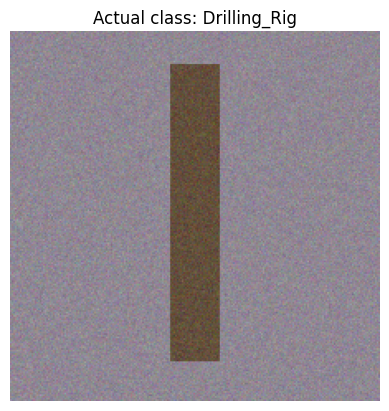


Predicted class: Drilling_Rig (71.05%)


In [31]:
# Use the trained ResNet model to make a prediction and print prediction percentages

# Set model to evaluation mode
resnet_model.eval()

# Prepare input tensor from pil_img (already defined)
input_tensor = val_transform(pil_img).unsqueeze(0).to(device)

# Get model output
with torch.no_grad():
    output = resnet_model(input_tensor)
    probs = torch.nn.functional.softmax(output[0], dim=0).cpu().numpy()

# Print prediction percentages for each class
print("Prediction Percentages:")
for i, class_name in model_manager.class_names.items():
    print(f"{class_name}: {probs[int(i)]*100:.2f}%")

# Print predicted class
predicted_class = probs.argmax()
# Print the image and actual class
plt.imshow(pil_img)
plt.axis('off')
actual_class = model_manager.class_names[str(sample_label)] if 'sample_label' in locals() else "Unknown"
plt.title(f"Actual class: {actual_class}")
plt.show()

print(f"\nPredicted class: {model_manager.class_names[str(predicted_class)]} ({probs[predicted_class]*100:.2f}%)")

## Summary & Validation

This is a simplified version of Experiment 7 for testing. The complete implementation would include model training, comparison, and deployment optimization.

**Key Components Demonstrated:**

- Transfer learning theory and pre-trained model advantages
- Multiple architecture support (ResNet, EfficientNet, MobileNet, ViT)
- Different fine-tuning strategies (feature extraction, fine-tuning, full training)
- Synthetic oil & gas equipment image generation
- ImageNet normalization and data augmentation

**Next Steps:**

- Implement training loops for different transfer learning strategies
- Add model comparison and performance benchmarking
- Include efficiency analysis (inference time, model size, accuracy)
- Implement model optimization for edge deployment
- Add comprehensive evaluation and visualization tools
